# Part 2 of interpretability of a Convnet model


In this case the idea now is to plot what the filters see when they activate at their highest level

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import math

2023-09-17 10:53:51.586740: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 10:53:52.387070: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_8835/1637373351.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# load the 3 models we already've trained

In [2]:
model1 = tf.keras.models.load_model("./checkpoints/model1/")
model2 = tf.keras.models.load_model("./checkpoints/model2/")
model3 = tf.keras.models.load_model("./checkpoints/esp32/")

# pretrained models
# model_pretrained = tf.keras.applications.InceptionV3(include_top=False)
model_pretrained = tf.keras.applications.ResNet50(include_top=False)

2023-09-17 10:53:54.617204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-17 10:53:54.693679: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-17 10:53:54.693825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
model_pretrained.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

# First step build a loss function

The idea is to maximize the activation

In [3]:
test_tensor = tf.expand_dims(tf.random.uniform(minval=0.4, maxval=0.6, shape=(256, 256, 3)), axis=0)

In [4]:
tf.reduce_mean(test_tensor)

<tf.Tensor: shape=(), dtype=float32, numpy=0.4999261>

In [5]:
tf.reduce_mean(tf.math.rsqrt(tf.math.reduce_euclidean_norm(test_tensor, axis=2)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.35242295>

In [6]:
tf.math.reduce_euclidean_norm(tf.reduce_mean(test_tensor, axis=2))

<tf.Tensor: shape=(), dtype=float32, numpy=13.854718>

In [7]:
def loss(activation):
    """
        initial_random_image: initial random image made to max out the activation of the filter.
        prediction: output of the filter's activation.
        Squared Error

        # Trying to maximize the activations average.
    """

    return tf.reduce_mean(activation)

In [8]:
def preproces_img(image_output):

    filter_patern = image_output.copy()

    mean = filter_patern.mean()
    std = filter_patern.std()

    filter_patern -= mean
    filter_patern /= std

    filter_patern *= 64
    filter_patern += 128
    
    filter_patern = np.clip(filter_patern, 0, 255).astype("uint8")

    #Center image
    return filter_patern[25:-25, 25:-25, :]

In [9]:
def get_convs_layers(model):
    outputs=[]
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.MaxPool2D)):
            layer.trainable=False
            outputs.append(layer)
    return outputs

In [10]:
def print_filters(model_name, layer_name, all_images, image_shape=(256, 256)):       
    margin = 5
    c = 4
    r = math.ceil(len(all_images)/c)

    cropped_width = image_shape[0]-25*2
    cropped_height = image_shape[1]-25*2

    width = r * cropped_width + (r-1) * margin
    height = c * cropped_height + (c-1) * margin

    stitched_filters = np.zeros((width, height, 3))

    #rows
    for i in tqdm(range(r)):
        for j in range(c):
            image = all_images[i * c +j]

            row_start= (cropped_width + margin) * i
            row_end = (cropped_height + margin) * i + cropped_width
            column_start = (cropped_height + margin) * j
            column_end = (cropped_height + margin) * j + cropped_height

            stitched_filters[row_start: row_end, column_start: column_end, :] = image

    tf.keras.utils.save_img(f"./part2-filters/{model_name}/{layer_name}.png", stitched_filters)

In [11]:
@tf.function
def optimize_step(feature_extractor_model, image, filter_index, lr):
    with tf.GradientTape() as tape:
        tape.watch(image)

        activation = feature_extractor_model(image)
        activation = activation[:, 2:-2, 2:-2, filter_index]

        loss_value = loss(activation)

    gradients = tape.gradient(loss_value, image)
    gradients = tf.math.l2_normalize(gradients)

    image += gradients*lr

    return image, loss_value

In [12]:
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 rescaling (Rescaling)       (None, 96, 96, 1)         0         
                                                                 
 reshape_1 (Reshape)         (None, 96, 96, 1)         0         
                                                                 
 1st_conv_3x3 (Conv2D)       (None, 94, 94, 4)         40        
                                                                 
 1st_max_pooling (MaxPoolin  (None, 47, 47, 4)         0         
 g2D)                                                            
                                                                 
 2nd_conv_3x3 (Conv2D)       (None, 45, 45, 8)         296       
                                                             

In [13]:
model = model3

filter_index = 0
sample_layer = model.get_layer("2nd_conv_3x3")
feature_extractor_model = tf.keras.Model(inputs=model.input, outputs=sample_layer.output)

lr=10.

In [14]:
sample_layer.weights

[<tf.Variable '2nd_conv_3x3/kernel:0' shape=(3, 3, 4, 8) dtype=float32, numpy=
 array([[[[-1.40028343e-01, -2.67298911e-02,  1.48277193e-01,
           -2.37517491e-01,  1.88622981e-01, -6.88541308e-02,
           -2.50501662e-01,  4.04042840e-01],
          [ 3.83383960e-01,  1.28064588e-01, -4.93256040e-02,
           -1.83572084e-01, -3.58526200e-01,  1.31047964e-01,
            2.41660830e-02, -4.29403722e-01],
          [ 1.07786961e-01, -1.89621434e-01, -4.19144928e-02,
            1.91629445e-03, -3.83982584e-02, -8.15100223e-02,
            1.11583196e-01, -9.72797796e-02],
          [-8.60694200e-02, -1.38065353e-01,  1.38167605e-01,
            1.41449973e-01, -6.39576986e-02,  1.45176604e-01,
            4.06289995e-02,  2.06412271e-01]],
 
         [[ 6.63981140e-02, -4.51402754e-01,  1.94872811e-01,
            1.77843049e-01,  2.11722001e-01,  1.30771101e-01,
            1.67938635e-01, -7.25899398e-01],
          [ 3.35591078e-01,  7.24966154e-02, -1.10932469e-01,
      

In [15]:
sample_layer.output

<KerasTensor: shape=(None, 45, 45, 8) dtype=float32 (created by layer '2nd_conv_3x3')>

[[153  81 142]
 [136  86 137]
 [135  89 138]]


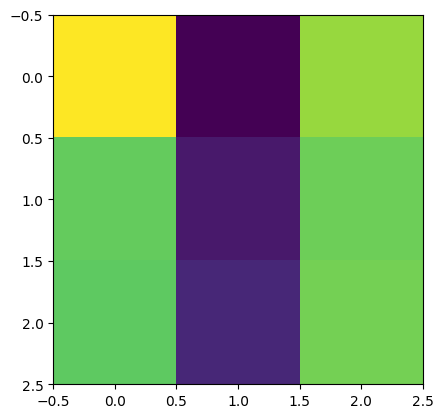

In [16]:
kernel = sample_layer.weights[0][:, :, 0, 7]

kernel *= 64
kernel += 128

kernel = np.array(np.clip(kernel, a_min=0, a_max=255), dtype=np.uint8)

print(kernel)

plt.imshow(kernel)
plt.show()

In [17]:
import os
import shutil
import gc

tf.keras.backend.clear_session()

image_shape_list = [(256, 256, 3), (256, 256, 3), (96, 96, 1), (299, 299, 3)]

models=[model1, model2, model3, model_pretrained]
models_name = ["model_1_new_version", "model_2_new_version", "model_3_new_version", "model_resnet50"]

epochs = 500
learning_rate = 10.

for model_name, model, image_shape in zip(models_name, models, image_shape_list):
    print(f"Model : {model_name}")

    if not os.path.exists(f"part2-filters/{model_name}/"):
        os.mkdir(f"part2-filters/{model_name}/")
    else:
        shutil.rmtree(f"part2-filters/{model_name}/")
        os.mkdir(f"part2-filters/{model_name}/")

    for layer in get_convs_layers(model):
        feature_extractor_model = tf.keras.Model(inputs=model.input, outputs=layer.output)
        images = []

        filters_count = layer.output.shape[-1]

        for filter_index in range(filters_count):
            noisy_image = tf.expand_dims(tf.random.normal(shape=image_shape), axis=0)

            for epoch in range(epochs):
                noisy_image, loss_value = optimize_step(feature_extractor_model, noisy_image, filter_index, learning_rate)

            images.append(preproces_img(noisy_image.numpy()[0].copy()))
        
        del feature_extractor_model
        tf.keras.backend.clear_session()
        gc.collect()

        print_filters(model_name=model_name, layer_name=layer.name, all_images=images, image_shape=image_shape)

Model : model_1_new_version


2023-09-16 20:40:06.421165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2023-09-16 20:40:06.850017: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Model : model_2_new_version


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Model : model_3_new_version


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Model : model_resnet50


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

: 